# Does age correlate with motion?

This has been bothering me for so many of our slack chats that I felt I really needed to start here.

What do we know about motion in our sample!?

In [11]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')
from scipy.stats import kurtosis
import sys

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
sys.path.append('../SCRIPTS/')
import kidsmotion_stats as kms
import kidsmotion_datamanagement as kmdm
import kidsmotion_plotting as kmp

### Get the data

In [13]:
behav_data_f = '../Phenotypic_V1_0b_preprocessed1.csv'

behav_df = kmdm.read_in_behavdata(behav_data_f)

### Motion measures

There are two measures we care about that can be used to index motion:

* func_mean_fd: mean framewise displacement, measured in mm
* func_perc_fd: percentage of frames that were more than 0.2mm displaced from the previous frame.

C:\Program Files\Anaconda3\envs\kwturing\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


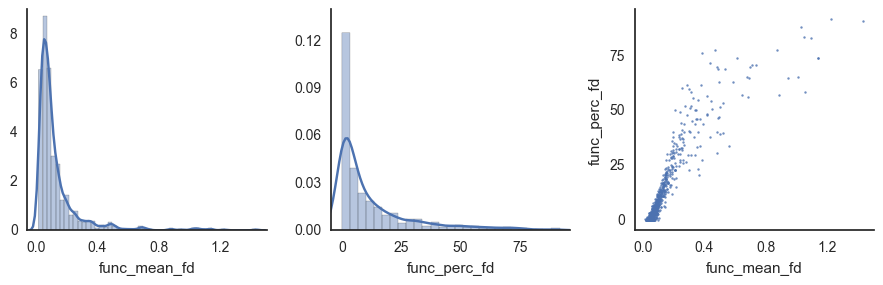

In [14]:
fig, ax_list = kmp.histogram_motion(behav_df)

# Note that there is a warning here but don't worry about it :P

We can see from the plot above that we have a data set of people who do not move all that much and that these two measures correlate well for low motion scans but start to diverge for the scans that have higher motion.

So, back to our original question, does motion correlate with age?

In [24]:
for var in ['func_mean_fd', 'func_perc_fd']:
    print(var)
    print('  kurtosis = {:2.1f}'.format(kurtosis(behav_df[var])))
    print('  corr with age:')
    kms.report_correlation(behav_df, 'AGE_AT_SCAN', var, covar_name=None, r_dp=2)

func_mean_fd
  kurtosis = 17.8
  corr with age:
    r = -0.13, p < .001
func_perc_fd
  kurtosis = 3.9
  corr with age:
    r = -0.16, p < .001


Yes! It does, and you can see that this correlation is stronger for func_perc_fd. I don't think this is really particularly important and I suspect it is driven by the kurtosis of the distribution. The func_mean_fd distribution is more non-normal (less normal?) than the func_perc_fd and I wonder if this causing the correlation to look messier. To be honest, I don't know and I don't really care. If this is what makes a big difference to our results I'll start to care more ;)

But hang on, we all know that it's important to *look at the data* so lets make a plot:

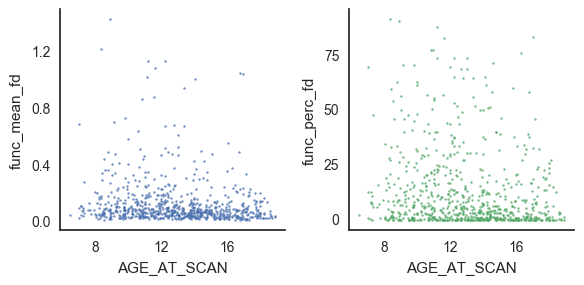

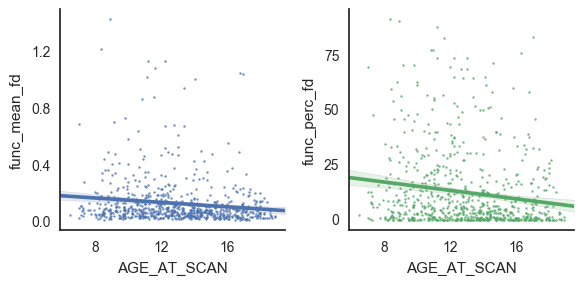

In [25]:
fig, ax_list = kmp.corr_motion_age(behav_df, fit_reg=False)
fig, ax_list = kmp.corr_motion_age(behav_df)

Well. That's underinspiring. Does that really count as a significant correlation? Gun to your head would you put that line there?

How does this correlation change when we look at different subsets of data? Specifically different ***age ranges***, ***motion thresholds*** and ***sample sizes***.

### How does sample size affect the relationship between age and motion?

The following plots show how sample size affects the relationship between age and motion (pearson's r).

I've kept the whole age range (6-18) and I'll show the same plot for 3 different motion thresholds (5%, 15%, 50% bad frames) and for a range of different sample sizes (25, 50, 75, 100, 125 and 150 participants each).

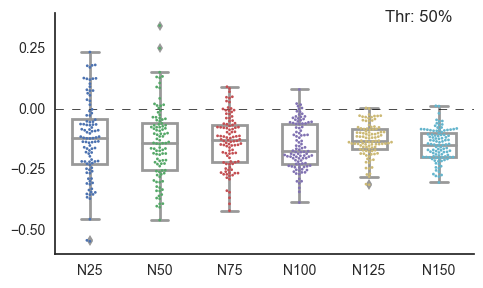

In [26]:
age_l = 6
age_u = 18
motion_measure='func_perc_fd'
n_perms = 100
motion_thresh = 50

corr_age_df = pd.DataFrame()

for n in [ 25, 50, 75, 100, 125, 150 ]:

    filtered_df = kmdm.filter_data(behav_df, motion_thresh, age_l, age_u, motion_measure=motion_measure)

    r_list = []
    for i in range(n_perms):
        sample_df = kmdm.select_random_sample(filtered_df, n=n)
        r, p = kms.calculate_correlation(sample_df, 'AGE_AT_SCAN', motion_measure, covar_name=None)
        r_list+=[r]

    corr_age_df['N{:2.0f}'.format(n)] = r_list

fig, ax = kmp.compare_groups_boxplots(corr_age_df, title='Thr: {:1.0f}%'.format(motion_thresh))

What I take from this plot is that there is a negative correlation between age and head motion (the older you are the less you move) and that the more participants we have in a sample the more consistent the measure (the narrower the box)

As John has said multiple times: the fact that more people gives you a better estimate of the population is kinda known already :P

So now we move to look at how the different thresholds affect this correlation...

### How does the motion cut off affect the relationship between age and motion?

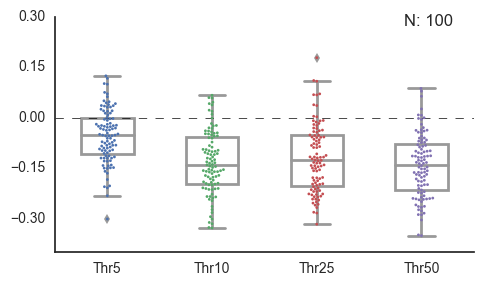

In [27]:
age_l = 6
age_u = 18
motion_measure='func_perc_fd'
n = 100
n_perms = 100

corr_age_df = pd.DataFrame()

for motion_thresh in [ 5, 10, 25, 50 ]:

    filtered_df = kmdm.filter_data(behav_df, motion_thresh, age_l, age_u, motion_measure=motion_measure)

    r_list = []
    for i in range(n_perms):
        sample_df = kmdm.select_random_sample(filtered_df, n=n)
        r, p = kms.calculate_correlation(sample_df, 'AGE_AT_SCAN', motion_measure, covar_name=None)
        r_list+=[r]

    corr_age_df['Thr{:1.0f}'.format(motion_thresh)] = r_list

fig, ax = kmp.compare_groups_boxplots(corr_age_df, title='N: {:1.0f}'.format(n))

What I take from this plot is that the correlation with age is less strong when you are more stringent in your exclusion criteria. Which makes sense: we're more likely to remove younger people and therefore reduce the correlation with age.

Next on the list is age range, do we see the same pattern across different ages?

### How does the age range of our cohort affect the relationship between age and motion?

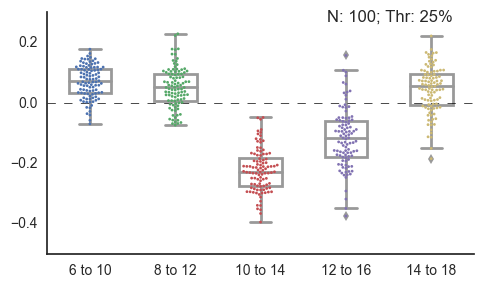

In [28]:
motion_measure='func_perc_fd'
n = 100
n_perms = 100
motion_thresh = 25

corr_age_df = pd.DataFrame()

for age_l in [ 6, 8, 10, 12, 14 ]:

    age_u = age_l + 4

    filtered_df = kmdm.filter_data(behav_df, motion_thresh, age_l, age_u, motion_measure=motion_measure)

    r_list = []
    for i in range(n_perms):
        sample_df = kmdm.select_random_sample(filtered_df, n=n)
        r, p = kms.calculate_correlation(sample_df, 'AGE_AT_SCAN', motion_measure, covar_name=None)
        r_list+=[r]

    corr_age_df['{:1.0f} to {:1.0f}'.format(age_l, age_u)] = r_list

fig, ax = kmp.compare_groups_boxplots(corr_age_df, title='N: {:1.0f}; Thr: {:1.0f}%'.format(n, motion_thresh))

Woah - that's interesting. In this sample we seem to only be able to detect a movement relationship for a 5 year age range (remember that the upper and lower limits are inclusive) when the participants are either 10-14 or 12-16 years old!

Is this pattern related to the threshold? What if we change that?

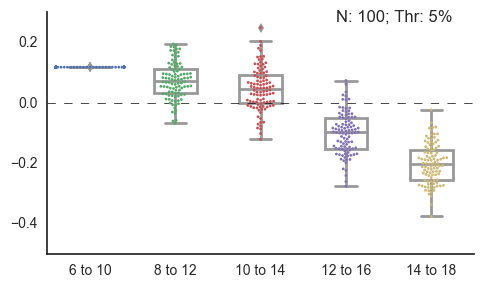

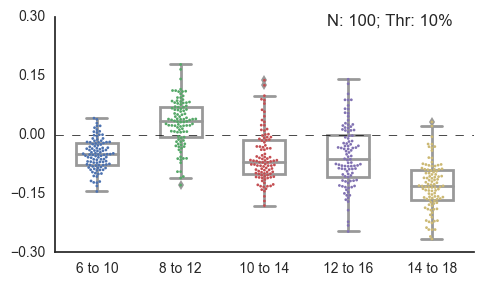

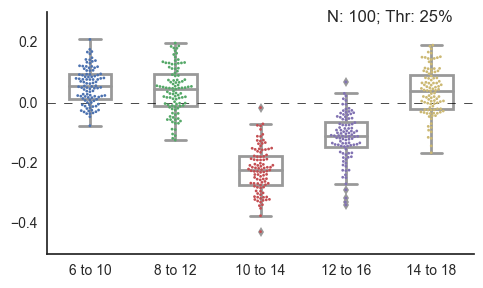

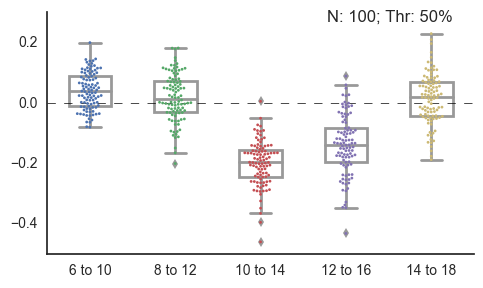

In [29]:
motion_measure='func_perc_fd'
n = 100
n_perms = 100
motion_thresh = 25

for motion_thresh in [ 5, 10, 25, 50 ]:
    corr_age_df = pd.DataFrame()

    for age_l in [ 6, 8, 10, 12, 14 ]:

        age_u = age_l + 4

        filtered_df = kmdm.filter_data(behav_df, motion_thresh, age_l, age_u, motion_measure=motion_measure)

        r_list = []
        for i in range(n_perms):
            sample_df = kmdm.select_random_sample(filtered_df, n=n)
            r, p = kms.calculate_correlation(sample_df, 'AGE_AT_SCAN', motion_measure, covar_name=None)
            r_list+=[r]

        corr_age_df['{:1.0f} to {:1.0f}'.format(age_l, age_u)] = r_list

    fig, ax = kmp.compare_groups_boxplots(corr_age_df, title='N: {:1.0f}; Thr: {:1.0f}%'.format(n, motion_thresh))

So, this to me is the crazy bit that I need to get my head around: there's different relationships with age for different thresholds. Which means, I think, that any of our results will change according to the thresholds we apply.

Now, I also want to see if we get the same pattern with a smaller number of participants in our cohort (you can see that we have fewer than 100 people in the very youngest group).

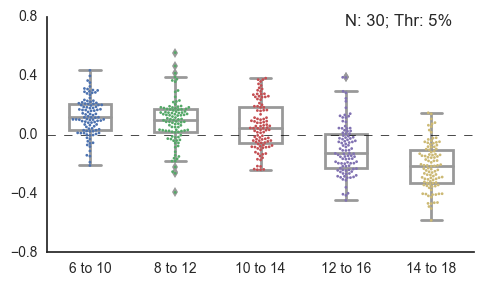

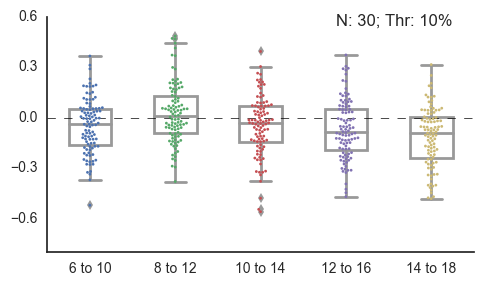

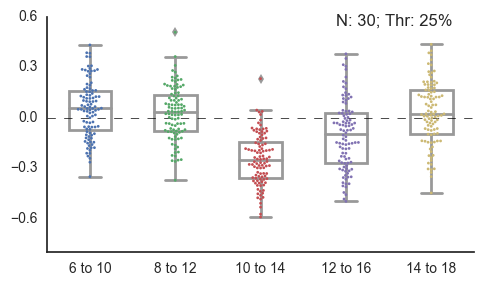

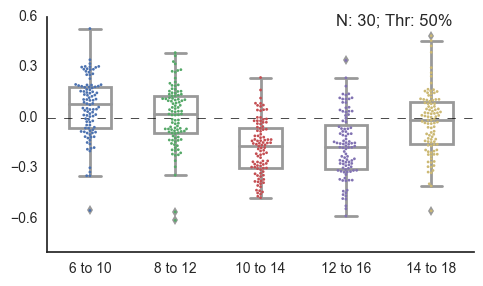

In [30]:
motion_measure='func_perc_fd'
n = 30
n_perms = 100
motion_thresh = 25

for motion_thresh in [ 5, 10, 25, 50 ]:
    corr_age_df = pd.DataFrame()

    for age_l in [ 6, 8, 10, 12, 14 ]:

        age_u = age_l + 4

        filtered_df = kmdm.filter_data(behav_df, motion_thresh, age_l, age_u, motion_measure=motion_measure)

        r_list = []
        for i in range(n_perms):
            sample_df = kmdm.select_random_sample(filtered_df, n=n)
            r, p = kms.calculate_correlation(sample_df, 'AGE_AT_SCAN', motion_measure, covar_name=None)
            r_list+=[r]

        corr_age_df['{:1.0f} to {:1.0f}'.format(age_l, age_u)] = r_list

    fig, ax = kmp.compare_groups_boxplots(corr_age_df, title='N: {:1.0f}; Thr: {:1.0f}%'.format(n, motion_thresh))

Yeah, we kinda do see the same pattern. The next thing to worry about is ensuring that our samples are matched on various measures. For example there may be a whole bunch of children with autism aged 11 in that 10-14 bin? I dunno...